In [2]:
import tkinter as tk
from tkinter import Frame, Canvas, Label, LEFT, RIGHT, Text, Scrollbar, INSERT, END, Button, Entry
import chess
import chess.pgn
from PIL import Image, ImageDraw, ImageFont, ImageTk
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

In [3]:
def eval_fun(fen): #returns the evaluation of all the variations
    evals = []
    moves = []
    board = chess.Board(fen)
    n_moves = len(list(board.legal_moves))
    with chess.engine.SimpleEngine.popen_uci(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\stockfish\stockfish-windows-x86-64-sse41-popcnt") as engine:
        vars = engine.analyse(board, chess.engine.Limit(time = 0.1), multipv = n_moves)
    for var in vars:
        var_score = str(var['score'].white())
        if var_score[0] == '#':
            evals.append((var_score[1] == '+')*5000 - (var_score[1] == '-')*5000)
        else:
            evals.append(int(var_score))
        moves.append(str(var['pv'][0]))  
    stock_policy = {move:eval for move, eval in zip(moves, evals)}
    return stock_policy
    
#Number of legal moves for each piece
def legal_moves_each_piece(fen):
    board = chess.Board(fen)
    
    legal_moves_count = {
        'P1':0, 'P2':0, 'P3':0, 'P4':0, 'P5':0, 'P6':0, 'P7':0, 'P8':0,  #White pawns
        'N1':0, 'N2':0,   #White knights
        'B1':0, 'B2':0,   #White Bishops
        'R1':0, 'R2':0,   #White Rooks
        'Q':0, 'K':0,     #White king and queen
        'p1':0, 'p2':0, 'p3':0, 'p4':0, 'p5':0, 'p6':0, 'p7':0, 'p8':0,  #Black pawns
        'n1':0, 'n2':0,   #Black knights
        'b1':0, 'b2':0,   #Black Bishops
        'r1':0, 'r2':0,   #Black Rooks
        'q':0, 'k':0,     #Black king and queen
    }
    
    piece_counts = {
        'P':0, 'N':0, 'B':0, 'R':0, 'Q':0, 'K':0,     #White pieces
        'p':0, 'n':0, 'b':0, 'r':0, 'q':0, 'k':0,     #Black pieces
    }
    
        # Function to generate piece names with counts
    def get_piece_name(piece, square):
        symbol = piece.symbol()
        piece_counts[symbol] += 1
        if symbol in 'Pp':
            # Separate pawns based on file (a-h) to distinguish them
            return symbol + str(chess.square_file(square) + 1)
        else:
            return symbol + str(piece_counts[symbol])

    # Iterate through all legal moves
    for move in board.legal_moves:
        # Get the piece at the origin square of the move
        piece = board.piece_at(move.from_square)
        if piece is not None:
            piece_name = get_piece_name(piece, move.from_square)
            if piece_name in legal_moves_count:
                legal_moves_count[piece_name] += 1

    # Create an array in the order of pieces
    piece_order = [
        'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8',
        'N1', 'N2', 'B1', 'B2', 'R1', 'R2', 'Q', 'K',
        'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8',
        'n1', 'n2', 'b1', 'b2', 'r1', 'r2', 'q', 'k'
    ]
    legal_moves_array = [legal_moves_count.get(piece, 0) for piece in piece_order]

    return legal_moves_array

#To find the ply number and side to play

def ply_number_fun(fen):
    board = chess.Board(fen)
    ply_number = board.fullmove_number * 2 - (1 if board.turn == chess.WHITE else 0)
    return ply_number

def side_to_play_fun(fen):
    board = chess.Board(fen)
    side_to_play = 1 if board.turn == chess.WHITE else 0
    return side_to_play

def time_to_seconds(time_str):
    h, m, s = time_str.split(':')
    result = int(h) * 3600 + int(m) * 60 + float(s)
    return int(result)

In [4]:
#import pickle

In [5]:
# with open(r'C:\Users\chinc\Desktop\Project_Assistant\model_xgb.pkl', 'rb') as f:
#     model_xgb_loaded = pickle.load(f)

In [4]:
#To load the model
from keras.saving import load_model
model = load_model(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\model_nn.h5")

1/1 [==============================] - 0s 344ms/step
Clicked on square: e4
No piece selected or wrong turn
Clicked on square: d2
Selected square: d2
Clicked on square: d4
Making move: d2d4
1/1 [==============================] - 0s 25ms/step
Clicked on square: f7
Selected square: f7
Clicked on square: f5
Making move: f7f5
1/1 [==============================] - 0s 39ms/step


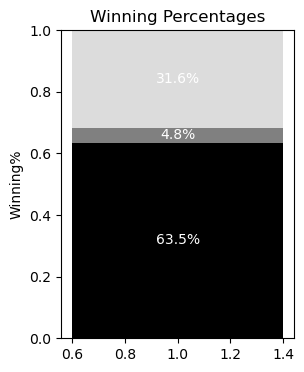

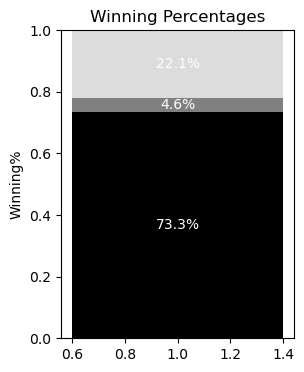

In [7]:
#Python GUI, for getting the updated plot for each half move

class ChessBoard:
    def __init__(self, root, wElo, bElo, incr, wTime, bTime):
        
        
        self.piece_images = self.load_piece_images()
        
        self.root = root
        self.current_move_index = 0
        self.board = chess.Board()
        
        self.boardFrame = Frame(root)
        self.boardFrame.pack(side=LEFT)
        
        # For Chess Board
        self.canvas = Canvas(self.boardFrame, width=400, height=400)
        self.canvas.pack()
        self.lblTurn = Label(self.boardFrame, text="White's Turn", font=("Arial", 16))
        self.lblTurn.pack()
        #self.lblFen = Label(self.boardFrame, text="", font=("Arial"))
        #self.lblFen.pack()
        self.selectedSquare = None
        self.isWhiteTurn = True
        self.board = chess.Board()
        
        self.newBtn = Button(self.boardFrame, text="Play New Game", command=self.new_game)
        self.newBtn.pack()
        
        self.drawBoard()
        self.canvas.bind("<Button-1>", self.selectSquare)
        self.updateLblFen()
        
        #For Graph
        self.graphFrame = Frame(root)
        self.graphFrame.pack(side=RIGHT)
        
        self.fig, self.ax = plt.subplots(figsize=(3, 4))
        self.canvasPlot = FigureCanvasTkAgg(self.fig, master=self.graphFrame)
        self.canvasPlot.get_tk_widget().pack()
        self.updateGraph()
        
    def load_piece_images(self):
        piece_images = {}
        # Load white pieces
        piece_images['P'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/white_pawn.png").resize((50, 50)))
        piece_images['R'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/white_rook.png").resize((50, 50)))
        piece_images['N'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/white_knight.png").resize((50, 50)))
        piece_images['B'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/white_bishop.png").resize((50, 50)))
        piece_images['Q'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/white_queen.png").resize((50, 50)))
        piece_images['K'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/white_king.png").resize((50, 50)))
        # Load black pieces
        piece_images['p'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/black_pawn.png").resize((50, 50)))
        piece_images['r'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/black_rook.png").resize((50, 50)))
        piece_images['n'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/black_knight.png").resize((50, 50)))
        piece_images['b'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/black_bishop.png").resize((50, 50)))
        piece_images['q'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/black_queen.png").resize((50, 50)))
        piece_images['k'] = ImageTk.PhotoImage(Image.open(r"C:\Users\chinc\Desktop\Project_Assistant\Chess_App\Images/black_king.png").resize((50, 50)))
        
        return piece_images
        
    def prediction(self, wElo, bElo, incr, wTime, bTime):
        
        fen = self.board.fen()
        legalMoves = legal_moves_each_piece(fen)
        legalMoves = np.array(legalMoves)
        plyNum = ply_number_fun(fen)

        #Extracting details
        w_elo = int(wElo)
        b_elo = int(bElo)
        inc = int(incr)
        w_time = int(bTime)
        b_time = int(wTime)
        
        stock_evals = eval_fun(fen)
        stock_evals = str(stock_evals)
        
        w_plus_all = []
        b_plus_all = []
        equals_all = []
        pos_evals = []
        expected_losses = []
        std_losses = []

        # Parameters
        thres = 20
        f = 4

        # Process stock evaluations for a single entry
        dict_eval = eval(stock_evals)
        move_evals = np.array(list(dict_eval.values()))
        pos_evals.append(move_evals[0])

        # Compute losses
        loss = np.abs(move_evals - move_evals[0])

        # Determine if white or black
        is_white = plyNum % 2
        alpha = (is_white * w_elo + (1 - is_white) * b_elo) / 3000

        # Calculate exponential loss
        expo_loss = np.exp(-f * alpha * 0.01 * loss)
        total_expo_loss = np.sum(expo_loss)
        expected_loss = np.dot(expo_loss, loss) / total_expo_loss
        expected_losses.append(expected_loss)
        std_losses.append(np.sqrt(np.dot(expo_loss, loss * loss) / total_expo_loss - expected_loss * expected_loss))

        # Count occurrences of evaluations above, below, and equal to the threshold
        w_plus = b_plus = equals = 0
        for item in dict_eval.values():
            if item > thres:
                w_plus += 1
            elif item < -thres:
                b_plus += 1
            else:
                equals += 1

        w_plus_all.append(w_plus)
        b_plus_all.append(b_plus)
        
        expected_losses = np.array(expected_losses)
        std_losses = np.array(std_losses)
        pos_evals = np.array(pos_evals)
        white_plus = np.array(w_plus_all)
        black_plus = np.array(b_plus_all)

        X_sam1 = np.append(legalMoves, (float(plyNum), float(w_elo), float(b_elo), float(w_time), float(b_time), float(inc)), axis = 0)
        X_sam1 = np.concatenate((X_sam1, expected_losses, std_losses, pos_evals, white_plus, black_plus))
        X_sam1 = np.array([X_sam1])
        Y_sam1 = model.predict(X_sam1)
        return Y_sam1
        
    def drawBoard(self):
        self.canvas.delete("all")
        colors = ["#DDB88C", "#A66D4F"]
        for row in range(8):
            for col in range(8):
                x1 = col * 50
                y1 = row * 50
                x2 = x1 + 50
                y2 = y1 + 50
                color = colors[(row + col) % 2]
                self.canvas.create_rectangle(x1, y1, x2, y2, fill=color)
                piece = self.board.piece_at(chess.square(col, 7-row))
                if piece:
                    img = self.piece_images[piece.symbol()]
                    self.canvas.create_image(x1 + 25, y1 + 25, image=img)
                    self.canvas.img = img
                    
    def selectSquare(self, event):
        col = event.x // 50
        row = 7 - event.y // 50
        square = chess.square(col, row)
        piece = self.board.piece_at(square)
        print(f"Clicked on square: {chess.square_name(square)}")
        if self.selectedSquare:
            move = chess.Move(self.selectedSquare, square)
            if move in self.board.legal_moves:
                print(f"Making move: {move.uci()}")
                self.board.push(move)
                self.selectedSquare = None
                self.isWhiteTurn = not self.isWhiteTurn
                self.updateLblTurn()
                self.updateGraph()
            else:
                print(f"Illegal move: {move.uci()}")
                self.selectedSquare = None
        else:
            if piece and ((piece.color == chess.WHITE and self.isWhiteTurn) or (piece.color == chess.BLACK and not self.isWhiteTurn)):
                self.selectedSquare = square
                print(f"Selected square: {chess.square_name(square)}")
            else:
                print("No piece selected or wrong turn")
        self.drawBoard()
        
    def updateLblTurn(self):
        if self.isWhiteTurn:
            self.lblTurn.config(text="White's Turn")
        else:
            self.lblTurn.config(text="Black's Turn")
        
    def updateLblFen(self):
        fen = self.board.fen()
        #self.lblFen.config(text=fen)
        
    def updateGraph(self):
        Y_sam1 = self.prediction(wElo, bElo, incr, wTime, bTime)
        
        blackPrt = [Y_sam1[0,0]]
        drawPrt = [Y_sam1[0,1]]
        whitePrt = [Y_sam1[0,2]]
        
        self.ax.clear()
        x = 1
        p1 = self.ax.bar(x, Y_sam1[0,0], color='black')
        p2 = self.ax.bar(x, Y_sam1[0,1], bottom=Y_sam1[0,0], color='grey')
        p3 = self.ax.bar(x, Y_sam1[0,2], bottom=Y_sam1[0,0]+Y_sam1[0,1], color='gainsboro')
        
        self.ax.set_ylim(0,1)
        self.ax.set_ylabel('Winning%')
        self.ax.set_title('Winning Percentages')
        
        for p, value in zip(p1, blackPrt):
            self.ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2., f'{value*100:.1f}%', ha='center', va='center', color='white')
        for p, value in zip(p2, drawPrt):
            self.ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2. + p1[0].get_height(), f'{value*100:.1f}%', ha='center', va='center', color='white')
        for p, value in zip(p3, whitePrt):
            self.ax.text(p.get_x() + p.get_width() / 2., p.get_height() / 2. + p1[0].get_height() + p2[0].get_height(), f'{value*100:.1f}%', ha='center', va='center', color='white')
        
        self.canvasPlot.draw()
        
    def new_game(self):
        self.root.destroy()
        main()
        
class GameInputApp:
    def __init__(self, root):
        self.root = root
        
        self.enter = Label(root, text="Enter the details")
        self.enter.grid(row=0, column=0, sticky='w', pady=20)
        
        self.weloLbl = Label(root, text='White Elo')
        self.weloLbl.grid(row=1, column=0, sticky='e', pady=20)
        self.welo = Entry(root)
        self.welo.grid(row=1, column=1, pady=20, padx=20)
        
        self.beloLbl = Label(root, text='Black Elo')
        self.beloLbl.grid(row=2, column=0, sticky='e', pady=20)
        self.belo = Entry(root)
        self.belo.grid(row=2, column=1, pady=20, padx=20)
        
        self.incLbl = Label(root, text='Increment in Time(s)')
        self.incLbl.grid(row=3, column=0, sticky='e', pady=20)
        self.inc = Entry(root)
        self.inc.grid(row=3, column=1, pady=20, padx=20)
        
        self.wtimeLbl = Label(root, text='White Time')
        self.wtimeLbl.grid(row=4, column=0, sticky='e', pady=20)
        self.wtime = Entry(root)
        self.wtime.grid(row=4, column=1, pady=20, padx=20)
        
        self.btimeLbl = Label(root, text='Black Time')
        self.btimeLbl.grid(row=5, column=0, sticky='e', pady=20)
        self.btime = Entry(root)
        self.btime.grid(row=5, column=1, pady=20, padx=20)
        
        self.submitButton = tk.Button(root, text="Submit", command=self.submitGame)
        self.submitButton.grid(row=6, column=0, sticky='e', pady=20)
        
    def submitGame(self):
        global wElo, bElo, incr, wTime, bTime
        
        wElo = self.welo.get()
        bElo = self.belo.get()
        incr = self.inc.get()
        wTime = self.wtime.get()
        bTime = self.btime.get()
        
        self.root.destroy()  # Close the PGN input window
        
        root = tk.Tk()
        chess_board = ChessBoard(root, wElo, bElo, incr, wTime, bTime)
        root.mainloop()

def main():
    root = tk.Tk()
    app = GameInputApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()
        
root = tk.Tk()
chess_board = ChessBoard(root, wElo, bElo, incr, wTime, bTime)
root.mainloop()